<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/smart-stats/ds4bio_book/HEAD)

# Parallelism and GPU computing

AI calculations involve quite a few arithmetic calculations. Graphics processing units (GPUs) are computer chips that were designed to parallelize large numbers of small arithmetic calculations. They were designed as such because computer graphics involve rotations, shifts, scaling, etc. of images, are matrix or tensor manipulations, i.e. a large collection of small arithmetic calculations.

This discussion is relevant, since there is a calculus of parallelization on whether or not it will be worth the effort. In fact, in some cases parallelization can slow down computations. For example, parallelizing across a network will only be beneficial if the cumulative cost of the network transfer is less than the cumulative benefit from parallization. For parallelizing lots of small calculations, the data transfer has to be really fast. What could be faster than on the same chip, like a GPU? The effect of GPU paralleziation on AI learning can be quite significant. We give a simple example below where we parallelize the sum of a few thousand numbers, where the acceleration is on the order of 50 to 70%.

## Getting started
I don't have a GPU in my personal computer. Some options for trying out GPUs include Google Colab and Paperspace to name two examples. I'm doing this example on Colab


In [1]:
import torch
torch.cuda.is_available()

True

By default, calculations will be on the CPU. You have to actually migrate calculations to the GPU. Here I write the code in such a way that it works on the GPU or CPU depending on whether a GPU is available. It's typical to create a variable called "device" that references the GPU.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else :
    device = torch.device("cpu")
print(device)

cuda:0


Here the GPU is called `cuda:0` referencing the CUDA API for GPU computing. CUDA is one framework for NVIDIA GPUs. It is very nice, since pytorch and other software have developed high level interfaces. You'll see how fast it is to incorporate GPU computing. Let's look at the reduction in runtime for a very simple example.

In [15]:
import time

for i in range(10):
  test_matrix = torch.randn([100000, 10])
  test_matrix_cuda = test_matrix.to(device)

  start = time.time()
  test_matrix.sum()
  end = time.time()

  a = end - start

  start = time.time()
  test_matrix_cuda.sum()
  end = time.time()

  b = end - start

  print("The % reduction in runtime is: ", end = "")
  print(np.round((1 - b / a) * 100, 1))


The % reduction in runtime is: 68.8
The % reduction in runtime is: 65.8
The % reduction in runtime is: 58.7
The % reduction in runtime is: 59.1
The % reduction in runtime is: 28.6
The % reduction in runtime is: 60.8
The % reduction in runtime is: 42.1
The % reduction in runtime is: 52.8
The % reduction in runtime is: 57.5
The % reduction in runtime is: 62.1


## Redoing our GAN example

Let's redo our GAN example using GPU acceleration. We won't even use random batches, since it runs so much faster.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import urllib.request
import PIL

## Read in and organize the data
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)
finalArray = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
    finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
    finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]

n = finalArray.shape[0]
x_real = finalArray / 255
x_real = torch.tensor(x_real.astype(np.float32)).to(device)
kernel_size = 5
generator_input_dim = [16, 3, 3]

class create_generator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(16, 128, 10, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)
 
## Use the discriminator from the convnet chapter
class create_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
        
generator = create_generator().to(device)
discriminator = create_discriminator().to(device)

lr = 1e-4

## y is n real images then n fake images
y = torch.concat( (torch.ones(n), torch.zeros(n) ) ).to(device)
## Note the outcome for the generator is all ones even
## though we're classifying real as 1 and fake as 0
## In other words, we want the loss for the generator to be
## based on how real-like the generated data is
y_fake = torch.ones( (n, 1) ).to(device)

## Set up optimizers
optimizerD = optim.Adam(discriminator.parameters(), lr=lr)
optimizerG = optim.Adam(generator.parameters(), lr=lr)

## Set up the loss function
loss_function = nn.BCELoss()

In [6]:
## I want an animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image

## Create a vector to keep track of
z = torch.randn([1]+generator_input_dim, device = device)
## Animation stuff
fig, ax = plt.subplots()
ims = []
plt.close(fig)

In [ ]:
n_epochs = 4000

for epoch in range(n_epochs):          
    ## Generate the simulated embedding    
    embedding = torch.randn([n]+generator_input_dim, device = device)    

    ## Generate new fake images
    x_fake = generator(embedding)
    
    ######################## train the discriminator
    ## zero out the gradient
    discriminator.zero_grad()

    ## run the generated and fake images through the discriminator
    yhat_fake = discriminator(x_fake.detach())
    yhat_real = discriminator(x_real)

    ## Note you have to concatenate them in the same order as 
    ## the previous cell. Remember we did real then fake
    yhat = torch.concat( (yhat_real, yhat_fake) ).reshape(-1)

    discriminator_error = loss_function(yhat, y)

    # Calculate gradients for D in backward pass
    discriminator_error.backward(retain_graph = True)

    # Update the discriminator
    optimizerD.step()

    ############### Train the generator

    ## zero out the gradient
    generator.zero_grad()

    ## The discriminator has been udpated, so push the data through the 
    ## new discriminator
    yhat_fake = discriminator(x_fake)
    
    generator_error = loss_function( yhat_fake,  y_fake )

    ## Calculate the backwards error
    generator_error.backward(retain_graph = False)

    # Update the discriminator
    optimizerG.step()
    
    if (epoch + 1) % 10 == 0:
      x_temp = generator(z).detach().cpu().numpy()[0, :, :, :]
      img = np.transpose(x_temp, (1, 2, 0))
      im = ax.imshow(img, animated=True)
      ims.append([im])


In [20]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=1000)
HTML(ani.to_html5_video())

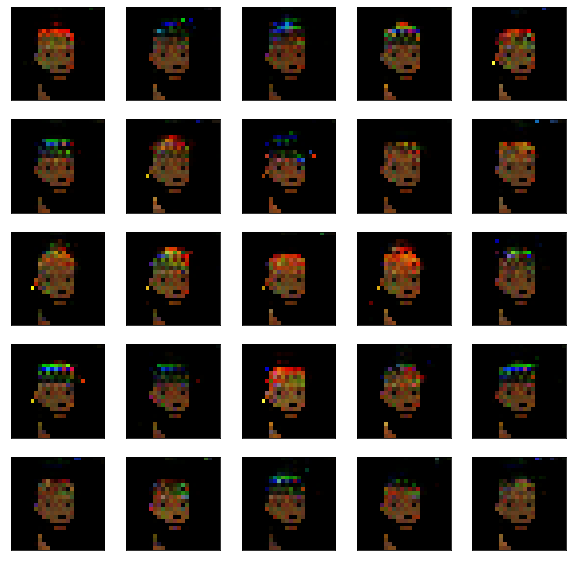

In [21]:
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(x_fake.detach().cpu().numpy()[i,:,:,:], (1, 2, 0))
  plt.imshow(img)  
